#### !!! WARNING !!! Before closing this file: If you want to commit modifications make sure you have clear the outputs of each cell.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from data_processing import *
from SVR import SVRmodel
from time import perf_counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sns.set_style("darkgrid")
data = extract("../Data/Postures.csv")
data.head()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,Class 1,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,...,?,?,?,?,?,?,?,?,?,?
1,Class 1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,...,?,?,?,?,?,?,?,?,?,?
2,Class 1,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,...,?,?,?,?,?,?,?,?,?,?
3,Class 1,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,...,?,?,?,?,?,?,?,?,?,?
4,Class 1,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,...,?,?,?,?,?,?,?,?,?,?


In [3]:
nb_data_points, features, missing_values, sensor_df, class_dist = data_params(data)
print("Number of data points = ",nb_data_points)
print("Number of features = ",features)
print("Number of sparse data points = ",missing_values)
print("Number of sensors =",(features-2)//3)

Number of data points =  78095
Number of features =  37
Number of sparse data points =  78064
Number of sensors = 11


In [4]:
sensor_df.head(20)

,Sensors,Missing datapoints
0,Sensor 0,0
1,Sensor 1,0
2,Sensor 2,0
3,Sensor 3,690
4,Sensor 4,3120
5,Sensor 5,13023
6,Sensor 6,25848
7,Sensor 7,39152
8,Sensor 8,47532
9,Sensor 9,54128


In [5]:
class_dist.head()

,Class,Number of data points
0,Class 1,16265
1,Class 2,14978
2,Class 3,16344
3,Class 4,14775
4,Class 5,15733


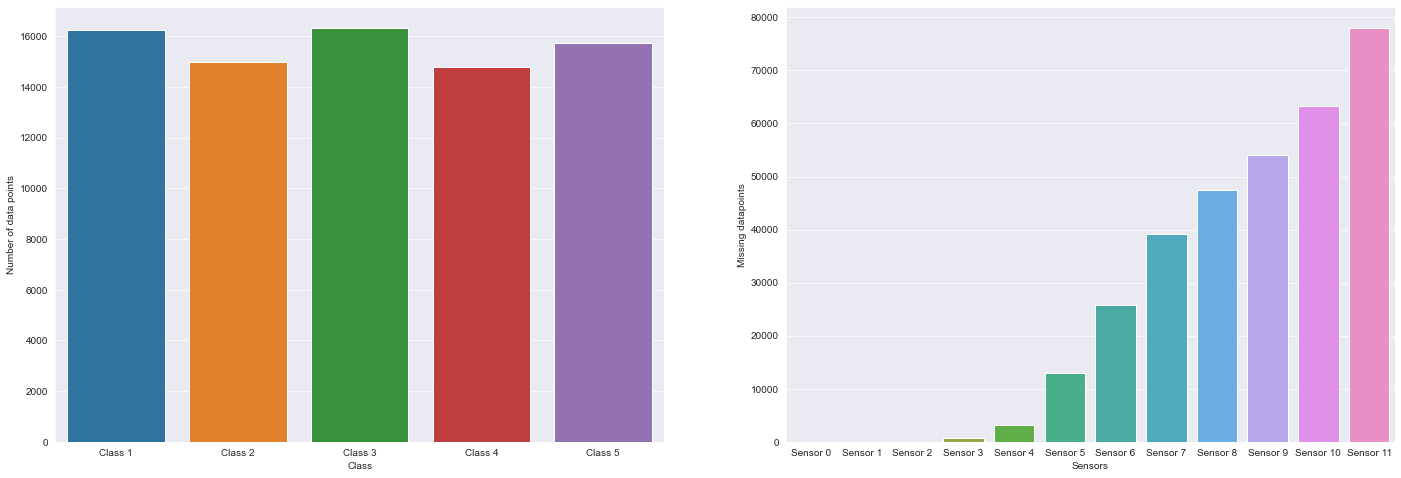

In [6]:
fig = plt.figure(figsize=[24,8])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(data=class_dist,x="Class",y="Number of data points",ax=ax1)
sns.barplot(data=sensor_df,x="Sensors",y="Missing datapoints",ax=ax2)
plt.show()

In [7]:
index = [i for i in range(0,11)]
Sensor_3 = data.iloc[:,index]
relevant_data = Sensor_3[(Sensor_3 == '?').any(axis=1) == False]
relevant_data.head()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3
0,Class 1,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.23226389
1,Class 1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.45087295
2,Class 1,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.83538757
3,Class 1,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.59615713
4,Class 1,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.36874806


In [8]:
subdataset = split_data(relevant_data,20)

In [9]:
for i in range(0,len(subdataset)):
    print("Class 1 subdataset ",i," ",(subdataset[i][:,1] == 1).sum())

Class 1 subdataset  0   749
Class 1 subdataset  1   749
Class 1 subdataset  2   749
Class 1 subdataset  3   749
Class 1 subdataset  4   749
Class 1 subdataset  5   749
Class 1 subdataset  6   749
Class 1 subdataset  7   749
Class 1 subdataset  8   749
Class 1 subdataset  9   749
Class 1 subdataset  10   749
Class 1 subdataset  11   749
Class 1 subdataset  12   749
Class 1 subdataset  13   749
Class 1 subdataset  14   749
Class 1 subdataset  15   749
Class 1 subdataset  16   749
Class 1 subdataset  17   749
Class 1 subdataset  18   748
Class 1 subdataset  19   748


In [10]:
subsub = split_data(subdataset[0],5,one_hot=False)
for i in range(0,len(subsub)):
    print("Class 1 subdataset ",i," ",(subsub[i][:,1] == 1).sum())

Class 1 subdataset  0   150
Class 1 subdataset  1   150
Class 1 subdataset  2   150
Class 1 subdataset  3   150
Class 1 subdataset  4   149


In [11]:
range_C = np.linspace(1,50,3)
range_gamma = np.linspace(0.1,2,3)
Model_SVR = SVRmodel(subsub,-1,range_C,range_gamma,kernel='rbf') 

In [12]:
print(Model_SVR.cross_test[0].shape)

(777, 15)


In [13]:
Model_SVR.train_models()

C = 1.0  gamma = 0.1
C = 1.0  gamma = 1.05
C = 1.0  gamma = 2.0
C = 25.5  gamma = 0.1
C = 25.5  gamma = 1.05
C = 25.5  gamma = 2.0
C = 50.0  gamma = 0.1
C = 50.0  gamma = 1.05
C = 50.0  gamma = 2.0


In [14]:
print(Model_SVR.test_grid)

[[1341.50695842 3350.10954844 3351.10924827]
 [3350.00807852 3354.98605905 3355.09441709]
 [3350.03480966 3354.60963963 3354.82454994]]


In [15]:
print(Model_SVR.train_grid)

[[2.67115041e+03 1.50049358e+00 1.56823637e+00]
 [1.46472571e+00 1.84312986e+00 1.85643717e+00]
 [1.47659398e+00 1.84292525e+00 1.85466614e+00]]


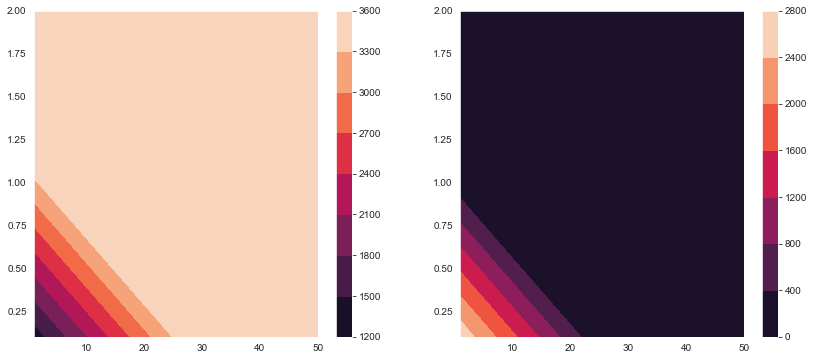

In [16]:
x = Model_SVR.grid_C
y = Model_SVR.grid_gamma
test = Model_SVR.test_grid
train = Model_SVR.train_grid
fig = plt.figure(figsize=[14,6])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
c1 = ax1.contourf(x,y,test)
c2 = ax2.contourf(x,y,train)
fig.colorbar(c2,ax=ax2)
fig.colorbar(c1,ax=ax1)
plt.show()